# Credit Risk Resampling Techniques

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")


import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

# Read the CSV and Perform Basic Data Cleaning

In [2]:
cols = [
    "loan_amnt",
    "int_rate",
    "installment",
    "home_ownership",
    "annual_inc",
    "verification_status",
    "issue_d",
    "loan_status",
    "pymnt_plan",
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "open_acc",
    "pub_rec",
    "revol_bal",
    "total_acc",
    "initial_list_status",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
    "next_pymnt_d",
    "collections_12_mths_ex_med",
    "policy_code",
    "application_type",
    "acc_now_delinq",
    "tot_coll_amt",
    "tot_cur_bal",
    "open_acc_6m",
    "open_act_il",
    "open_il_12m",
    "open_il_24m",
    "mths_since_rcnt_il",
    "total_bal_il",
    "il_util",
    "open_rv_12m",
    "open_rv_24m",
    "max_bal_bc",
    "all_util",
    "total_rev_hi_lim",
    "inq_fi",
    "total_cu_tl",
    "inq_last_12m",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "bc_util",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mort_acc",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "pct_tl_nvr_dlq",
    "percent_bc_gt_75",
    "pub_rec_bankruptcies",
    "tax_liens",
    "tot_hi_cred_lim",
    "total_bal_ex_mort",
    "total_bc_limit",
    "total_il_high_credit_limit",
    "hardship_flag",
    "debt_settlement_flag",
]

target = "loan_status"

## Cleaning of Data

In [3]:
# Load the data
file_path = Path("Resources/LoanStats_2019Q1.csv")
df = pd.read_csv(file_path, skiprows=1, usecols=cols)[:-2]

# Drop the null columns where all values are null
df.dropna(inplace=True, axis=1, how="all")

# Drop the null rows
df.dropna(
    inplace=True, axis=0, how="any"
)  # TODO: Evaluate which rows are being dropped

# Remove the `Issued` loan status rows
df = df.loc[df[target] != "Issued"].copy(deep=True)

# Convert interest rate to numerical
df["int_rate"] = df["int_rate"].str.replace("%", "").astype("float") / 100

# Convert the target column values to low_risk and high_risk based on their values
df[target] = df[target].str.replace("Current", "low_risk")

high_risk_pattern = [
    "Late (31-120 days)",
    "Late (16-30 days)",
    "Default",
    "In Grace Period",
]
df[target] = df[target].replace(high_risk_pattern, "high_risk")
# print(df.loan_status.unique()) # check to see if only low_risk and high_risk exist

# Reset index
df.reset_index(inplace=True, drop=True)

## Evaluate Categorical Values

In [4]:
# pandas.get_dummies encodes dtype of `object` or `category`
# check dtypes of data
df.dtypes.value_counts()

float64    76
object     10
dtype: int64

In [5]:
# Determine categorical features as defined by pd.get_dummies function (object and categories)
categorical_features = df.select_dtypes(include=[object]).columns.values.tolist()
# Only need to include `object` dtype since there are no categories dtypes assigned
categorical_features

['home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'initial_list_status',
 'next_pymnt_d',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

In [6]:
# Remove target value from being encoded
categorical_features.remove(target)

# Split the Data into Training and Testing

In [7]:
# Create our features
X = pd.get_dummies(
    df.drop([target], axis=1), columns=categorical_features
)  # Convert categorical variable into dummy/indicator variables

# Create our target
y = df[target]

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [9]:
# Check the balance of our target values
print(y.value_counts())

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    # test_size = .1
    # stratify=y,
    # shuffle=False,
    random_state=1,
)

# Oversampling

Compare two oversampling algorithms to determine which algorithm results in the best performance. Over-sample the data using the naive random oversampling algorithm and the SMOTE algorithm.

1. View the count of the target classes using `Counter` from the collections library.
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classification report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [11]:
# Resample the training data with the RandomOversampler
print("Original dataset shape %s" % Counter(y))

ros = RandomOverSampler(random_state=1)
X_train_resample, y_train_resample = ros.fit_resample(X_train, y_train)

print("Resampled dataset shape %s" % Counter(y_train_resample))

Original dataset shape Counter({'low_risk': 68470, 'high_risk': 347})
Resampled dataset shape Counter({'low_risk': 51366, 'high_risk': 51366})


In [12]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver="lbfgs", random_state=1)
model.fit(X_train_resample, y_train_resample)

LogisticRegression(random_state=1)

In [13]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6463970560994359

In [14]:
# Display the confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred, normalize=None))

,0,1
0,72,29
1,7185,9919


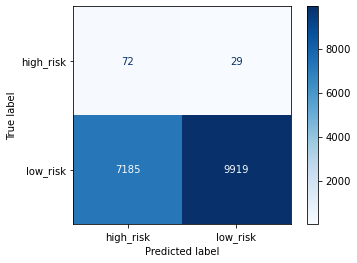

In [15]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()

In [16]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred, digits=3))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk      0.010     0.713     0.580     0.020     0.643     0.419       101
   low_risk      0.997     0.580     0.713     0.733     0.643     0.408     17104

avg / total      0.991     0.581     0.712     0.729     0.643     0.408     17205



### SMOTE Oversampling

In [17]:
# Resample the training data with SMOTE
print("Original dataset shape %s" % Counter(y))

X_train_resample, y_train_resample = SMOTE(
    random_state=1, sampling_strategy="auto"
).fit_resample(X_train, y_train)

print("Resampled dataset shape %s" % Counter(y_train_resample))

Original dataset shape Counter({'low_risk': 68470, 'high_risk': 347})
Resampled dataset shape Counter({'low_risk': 51366, 'high_risk': 51366})


In [18]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver="lbfgs", random_state=1, max_iter=100)
model.fit(X_train_resample, y_train_resample)
y_pred = model.predict(X_test)

In [19]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.6586230769943224

In [20]:
# Display the confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred, normalize=None))

,0,1
0,64,37
1,5412,11692


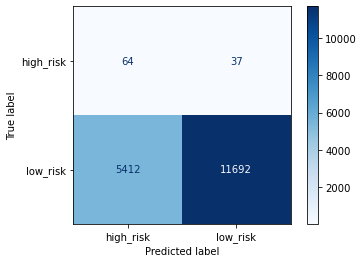

In [21]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()

In [22]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred, digits=3))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk      0.012     0.634     0.684     0.023     0.658     0.431       101
   low_risk      0.997     0.684     0.634     0.811     0.658     0.435     17104

avg / total      0.991     0.683     0.634     0.806     0.658     0.435     17205



# Undersampling

Test an under sampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. Under-sample the data using the Cluster Centroids algorithm:

1. View the count of the target classes using `Counter` from the collections library.
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classification report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [23]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
print("Original dataset shape %s" % Counter(y))

cc = ClusterCentroids(random_state=1)
X_train_resample, y_train_resample = cc.fit_resample(X_train, y_train)

print("Resampled dataset shape %s" % Counter(y_train_resample))

Original dataset shape Counter({'low_risk': 68470, 'high_risk': 347})
Resampled dataset shape Counter({'high_risk': 246, 'low_risk': 246})


In [24]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver="lbfgs", random_state=1, max_iter=100)
model.fit(X_train_resample, y_train_resample)
y_pred = model.predict(X_test)

In [25]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.5447339051023905

In [26]:
# Display the confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred, normalize=None))

,0,1
0,70,31
1,10324,6780


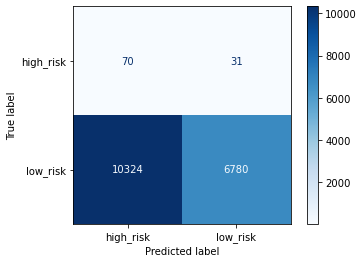

In [27]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred, digits=3))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk      0.007     0.693     0.396     0.013     0.524     0.283       101
   low_risk      0.995     0.396     0.693     0.567     0.524     0.267     17104

avg / total      0.990     0.398     0.691     0.564     0.524     0.267     17205



# Combination (Over and Under) Sampling

Test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. Resample the data using the SMOTEENN algorithm and complete the following steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classification report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [29]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
print("Original dataset shape %s" % Counter(y))

smote_enn = SMOTEENN(random_state=1)
X_train_resample, y_train_resample = smote_enn.fit_resample(X_train, y_train)

print("Resampled dataset shape %s" % Counter(y_train_resample))

Original dataset shape Counter({'low_risk': 68470, 'high_risk': 347})
Resampled dataset shape Counter({'high_risk': 51361, 'low_risk': 46653})


In [30]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver="lbfgs", random_state=1, max_iter=100)
model.fit(X_train_resample, y_train_resample)
y_pred = model.predict(X_test)

In [31]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.6361059077142514

In [32]:
# Display the confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_pred, normalize=None))

,0,1
0,69,32
1,7029,10075


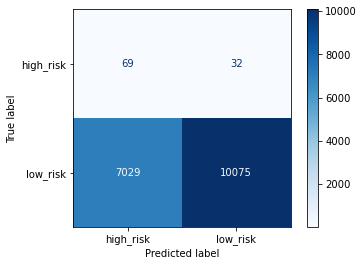

In [33]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", values_format="d"
)
plt.show()

In [34]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred, digits=3))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk      0.010     0.683     0.589     0.019     0.634     0.406       101
   low_risk      0.997     0.589     0.683     0.741     0.634     0.399     17104

avg / total      0.991     0.590     0.683     0.736     0.634     0.399     17205

